In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!curl -LJO https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/anime.csv
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.5M  100 13.5M    0     0  15.6M      0 --:--:-- --:--:-- --:--:-- 15.6M


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
def preprocesador(text):
    if isinstance(text, str):
        text = text.lower()           # pasar a minúsculas
        text = " ".join(text.split()) # eliminar espacios múltiples, tabs, saltos de línea, etc.
        return text
    return text  # si no es texto (por ejemplo un número o NaN), lo deja igual


El embending es una forma simplificada numerica de escribir un texto, estos vectores capturan el significado semantico y la relacion entre las palabras para el posterior procesamiento

Textos con significados parecidos → tendrán vectores cercanos entre sí.

In [4]:
series_data = pd.read_csv('anime.csv', sep=',', header=0)

# Aplicar la función a todo el DataFrame
series_data = series_data.map(preprocesador)

attack_on_titan_titles = series_data[series_data['title'] == "attack on titan"]

titulo_att = attack_on_titan_titles['title'].tolist()

embedding_att = model.encode(titulo_att, show_progress_bar=True)
print(embedding_att.shape)


series_data.head()




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 768)


,title,680973,682775,682809,684730,684840,684862,685362,686426,686489,...,1388155,1389510,1389679,1390094,1391050,1392101,1392278,1392522,1393478,1393558
0,"""deji"" meets girl",-1.0,8.0,7.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,"""ippon"" again!",-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,2.0,...,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
2,"'tis time for ""torture,"" princess",-1.0,8.0,7.0,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,8.0,-1.0,6.0,-1.0,-1.0,6.0,-1.0
3,"'tis time for ""torture,"" princess season 2",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0 years old child starting dash story,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


El embending resulta de (1, 768) es decir que se codifico una oracion y se tiene un vector de 768 columnas para explicar su significado

In [5]:
embeddings = model.encode(series_data["title"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

La similitud coseno mide el coseno del ángulo entre dos vectores en un espacio de embeddings. Cuanto más cercano a 1 sea su valor, más similares son las representaciones vectoriales.
En este contexto, permite comparar los embeddings de distintos títulos y, a partir de uno dado, encontrar las series más parecidas según su proximidad semántica.

In [6]:
def simil_coseno(emb1 , emb2): #saca el angulo entre dos vectores
  num = np.dot(emb1, emb2)
  den = np.linalg.norm(emb1) * np.linalg.norm(emb2)
  if den == 0:
    return 0
  else:
    return num/den


emb1 = model.encode("attack on titan")
emb2 = model.encode("naruto")

print("Similitud coseno:", simil_coseno(emb1, emb2))


Similitud coseno: 0.174741


In [7]:
def buscador_k_series(titulo, k):
    # Obtener embedding de la consulta
    titulo_emb = model.encode(titulo)

    # Calcular similitud con todos los embeddings
    similitudes = []
    for emb in embeddings:
        similitudes.append(simil_coseno(titulo_emb, emb))  #las vas guardando

    # Obtener los índices de los k más parecidos
    top_k = np.argsort(similitudes)[-k-1:][::-1]  # orden descendente
    top_k = top_k[1:] #saco el primero, porque siempre va a tener la maxima similitud consigo mismo
    resultados = series_data.iloc[top_k][['title']].copy()
    resultados['similitud'] = [similitudes[i] for i in top_k]

    return resultados





In [20]:
#resultados = buscador_k_series("attack on titan", k=5)
#print(resultados)

resultados2 = buscador_k_series("giant", k=15)
print(resultados2)


                       title  similitud
841      giant beasts of ars   0.654885
2084            super hxeros   0.552468
1541              megane-bu!   0.551769
2005              re:monster   0.543036
1848             overlord ii   0.541113
1539               megalobox   0.535180
2314               super cub   0.534595
1847                overlord   0.534339
2502  the great warrior wall   0.520100
384               bullbuster   0.519549
646        dragon ball super   0.515048
976             heavy object   0.509278
1903          plus-sized elf   0.489508
2388         tearmoon empire   0.475996
1849            overlord iii   0.474768


En este caso, al realizar la búsqueda con el título "giant", a diferencia de cuando se utiliza un título más específico como "Attack on Titan", se observa que el modelo no solo devuelve resultados con nombres similares, sino también títulos semánticamente relacionados.
Esto se debe a que el buscador captura el significado de las palabras, por lo que los resultados obtenidos están vinculados con el concepto de “cosas grandes”, reflejando una relación semántica más profunda que una simple coincidencia textual.

In [9]:
class buscador:
  def __init__(self, embeddings, series_data):
    self.embeddings = embeddings
    self.series_data = series_data
    self.model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

  def simil_coseno(emb1 , emb2): #saca el angulo entre dos vectores
    num = np.dot(emb1, emb2)
    den = np.linalg.norm(emb1) * np.linalg.norm(emb2)
    if den == 0:
      return 0
    else:
      return num/den

  def buscador_k_series(self ,titulo, k):
    # Obtener embedding de la consulta
    titulo_emb = self.model.encode(titulo)

    # Calcular similitud con todos los embeddings
    similitudes = []
    for emb in self.embeddings:
        similitudes.append(simil_coseno(titulo_emb, emb))  #las vas guardando

    # Obtener los índices de los k más parecidos
    top_k = np.argsort(similitudes)[-k-1:][::-1]  # orden descendente
    top_k = top_k[1:] #saco el primero, porque siempre va a tener la maxima similitud consigo mismo
    # Mostrar resultados
    resultados = self.series_data.iloc[top_k][['title']].copy()
    resultados['similitud'] = [similitudes[i] for i in top_k]

    return resultados

##Modelo de Filtrado Colaborativo

El modelo busca predecir los **ratings faltantes** en una matriz de usuarios vs. películas.  
Cada usuario y cada película se representan mediante vectores en un **espacio latente** de dimensión *k*.

El rating predicho del usuario \( u \) para la película \( i \) es:

$$
\hat{Y}_{i,u} = X_i^\top \Theta_u
$$

Esto se interpreta como una medida de **qué tan compatible es la película con los gustos del usuario**.

- Si $\hat{Y}_{i,u}$ es alto → el modelo predice que al usuario le gustará la película.  
- Si $\hat{Y}_{i,u}$ es bajo → el modelo predice que no le gustará.

**Entrenamiento por gradiente descendente:**

Durante el entrenamiento, los vectores $X$  y $\Theta$ se ajustan para minimizar el **error cuadrático** entre los ratings reales y los predichos, agregando una penalización de regularización, se tiene el costo empirico regularizado:

$$
J(X, \Theta) =
\frac{1}{2} \sum_{(i,u)\in R} (X_i^\top \Theta_u - Y_{i,u})^2
+ \frac{\lambda}{2} (\|X\|_F^2 + \|\Theta\|_F^2)
$$

donde:

- $Y \in \mathbb{R}^{n_{items} \times n_{users}}$ contiene las puntuaciones observadas.  
- $R = \{(i,j): y_{i,j}$ observado$\}$ es el conjunto de pares con datos cargados.  
- $X \in \mathbb{R}^{n_{items} \times \nu}$ son los vectores latentes de los ítems (filas $x_i^T$), es decir las categorias en las que se separan las series y se les asigna un puntaje.  
- $\theta \in \mathbb{R}^{n_{users} \times \nu}$ son los vectores latentes de los usuarios (filas $\theta_j^T$), es decir los puntajes que cada usuario le asigna a cada categoria.  
- $\lambda \ge 0$ es el hiperparámetro de regularización.  

Tiene 2 partes:
Error de reconstrucción (empírico):
mide qué tan bien el modelo predice los ratings observados

Regularización:
penaliza que los vectores latentes $x$ ,$\theta$ sean muy grandes, lo que controla el overfitting

**Gradiente por elemento**

Derivada respecto de $x_i$ :

$$
\frac{\partial L}{\partial x_i}
= \sum_{j:(i,j)\in R} (\theta_j^T x_i - y_{i,j}) \, \theta_j + \lambda \, x_i
$$

Derivada respecto de $\theta_j$:

$$
\frac{\partial L}{\partial \theta_j}
= \sum_{i:(i,j)\in R} (\theta_j^T x_i - y_{i,j}) \, x_i + \lambda \, \theta_j
$$

Estas expresiones se utilizan para actualizar los factores latentes de cada ítem y usuario.


**Forma matricial (vectorizada)**

Definimos:

- $M$  = máscara de observaciones, lo cual se usa para solo quedarnos con los ratings realizados, no teniendo en cuenta los -1

Sea el error:

$$
e = (X \Theta^T - Y) \cdot M
$$

Los gradientes vectorizados resultan:

$$
\nabla_X L = e \Theta + \lambda X
$$

$$
\nabla_\Theta L =e^T X + \lambda \Theta
$$


**Actualización por Descenso del Gradiente**

Con tasa de aprendizaje $\eta > 0$:

$$
X = X - \eta (e \Theta + \lambda X)
$$

$$
\Theta = \Theta - \eta (e^T X + \lambda \Theta)
$$


**Inferencia (Combinación Convexa de Factores)**

Durante la predicción se puede combinar la estimación del modelo con el promedio histórico de cada ítem:

$$
\hat{y}_{i,j} = p (\theta_j^T x_i) + (1 - p)\,\bar{y}_i
$$

donde $\bar{y}_i$ es la calificación promedio del ítem $i$ y $0 \le p \le 1$ pondera el peso entre el modelo aprendido y el valor medio.




In [10]:
# Crear lista para guardar ratings manualmente
ratings_usuario = []

#creo el buscador
buscador_serie = buscador(embeddings, series_data)
#saco 10 titulos
resultados_busqueda = buscador_serie.buscador_k_series("attack on titan", 10)

titulos_propios = resultados_busqueda["title"].tolist() #titulos de las series que voy a ratear

ratings_propios = [10 , 7, 5, 6, 3, 10, 9, 8, 7, 5]

#los junto en 2 columnas
ratings_usuario = list(zip(titulos_propios, ratings_propios))
print(ratings_usuario)


# Crear una nueva columna en series_data con -1 como valor por defecto
series_data["user_1_rating"] = -1.0

# Cargar los ratings del usuario en esa columna
for titulo, rating in ratings_usuario:
    idx = series_data.index[series_data["title"] == titulo].tolist()
    if len(idx) > 0:
        series_data.loc[idx[0], "user_1_rating"] = rating



[('attack on titan season 3', 10), ('attack on titan season 3 part 2', 7), ('attack on titan season 2', 5), ('attack on titan: final season part 2', 6), ('attack on titan: final season', 3), ('attack on titan: junior high', 10), ('giant killing', 9), ("the strongest tank's labyrinth raids -a tank with a rare 9999 resistance skill got kicked from the hero's party-", 8), ('space battleship tiramisu', 7), ('vivid strike!', 5)]


In [11]:
def loss(X, Theta, Y, M, lambd): #fuuncion de costo regularizado
    E = (X @ Theta.T - Y) * M
    return 0.5 * np.sum(E**2) + (lambd/2)*(np.sum(X**2) + np.sum(Theta**2))

In [13]:
k_latente = 15      # dimensión del espacio latente
lambd = 10          # regularización
eta = 1e-3          # learning rate
n_iter = 2000       # iteraciones

#nos quedamos con todas las columnas menos la de los titulos
ratings_cols = [c for c in series_data.columns if c != "title"]
Y = series_data[ratings_cols].values.astype(float)

# Creamos la máscara M (1 si hay rating, 0 si no)
M = (Y != -1).astype(float)

# Solo normalizamos los valores válidos (donde M == 1)
Y_norm = Y.copy()
Y_valid = Y[M == 1]
Y_min, Y_max = np.min(Y_valid), np.max(Y_valid)
Y_norm[M == 1] = (Y[M == 1] - Y_min) / (Y_max - Y_min)

n_items, n_users = Y.shape

#inicializo random
np.random.seed(22)
X = np.random.normal(scale=0.1, size=(n_items, k_latente))
Theta = np.random.normal(scale=0.1, size=(n_users, k_latente))

#entrenamiento
losses = []

for it in range(n_iter):
    # entreno solo con la informacion real, por eso se usa la mascara M
    E = ((X @ Theta.T) - Y_norm) * M

    # Gradientes vectorizados
    dX = E @ Theta + lambd * X
    dTheta = E.T @ X + lambd * Theta

    # Actualización
    X -= eta * dX
    Theta -= eta * dTheta

    # Guardar pérdida actual
    current_loss = loss(X, Theta, Y_norm, M, lambd)
    losses.append(current_loss)

    if it % 100 == 0:
        print(f"Iter {it}, loss = {current_loss:.4f}")

Iter 0, loss = 181436.9104
Iter 100, loss = 18190.2035
Iter 200, loss = 17630.2665
Iter 300, loss = 17503.2352
Iter 400, loss = 17447.6712
Iter 500, loss = 17423.3133
Iter 600, loss = 17415.1754
Iter 700, loss = 17412.3636
Iter 800, loss = 17411.1073
Iter 900, loss = 17410.3176
Iter 1000, loss = 17409.6671
Iter 1100, loss = 17409.0670
Iter 1200, loss = 17408.5080
Iter 1300, loss = 17408.0044
Iter 1400, loss = 17407.5705
Iter 1500, loss = 17407.2120
Iter 1600, loss = 17406.9254
Iter 1700, loss = 17406.7009
Iter 1800, loss = 17406.5265
Iter 1900, loss = 17406.3907


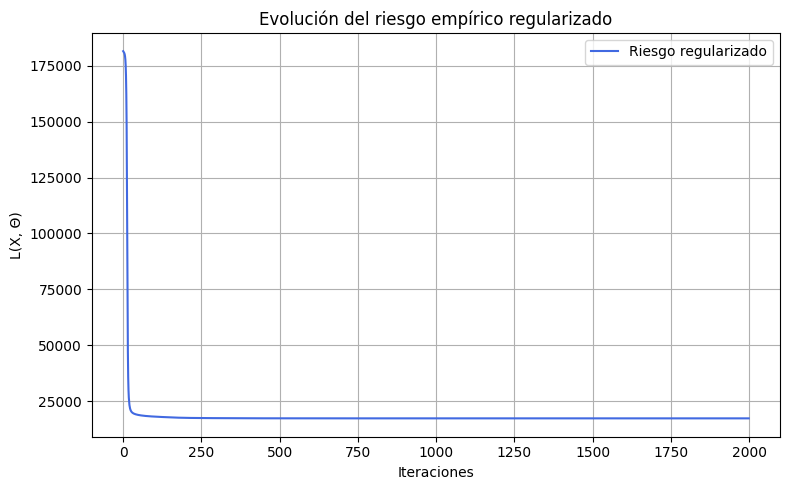

In [14]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(n_iter), losses, label="Riesgo regularizado", color="royalblue")
plt.xlabel("Iteraciones")
plt.ylabel("L(X, Θ)")
plt.title("Evolución del riesgo empírico regularizado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

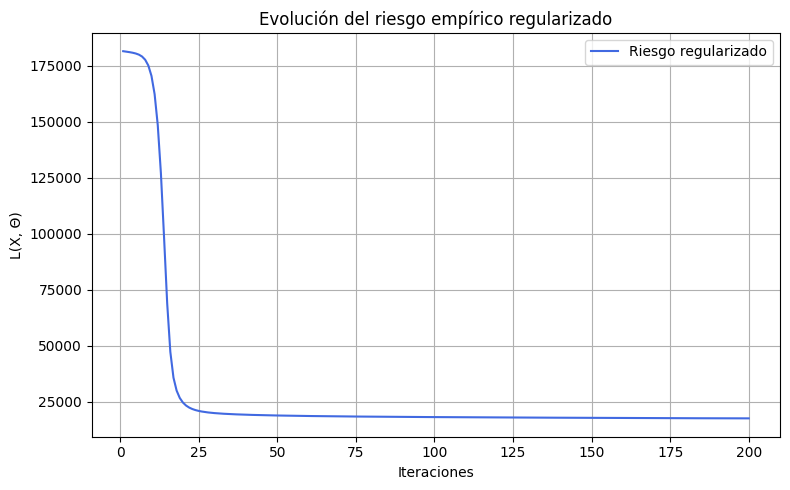

In [26]:
k = np.linspace(1, 200, 200)
plt.figure(figsize=(8,5))
plt.plot(k, losses[:200], label="Riesgo regularizado", color="royalblue")
plt.xlabel("Iteraciones")
plt.ylabel("L(X, Θ)")
plt.title("Evolución del riesgo empírico regularizado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Se puede observar que, al analizar el comportamiento del riesgo empírico en función del número de iteraciones, inicialmente este disminuye de manera abrupta debido a la inicialización aleatoria del algoritmo, que provoca que los gradientes tengan valores grandes y generen correcciones significativas. Tras las primeras aproximadamente 200 iteraciones, la disminución se ralentiza y el riesgo empírico tiende a estabilizarse, alcanzando prácticamente un punto estacionario.

In [22]:

#ahora hago la prediccion, y contiene todos los ratings
#x = categorias vs pelicuas
# tita = usuarios vs peliculas
Y_pred = X @ Theta.T


#tomo la media para tenerla en cuenta en el rating
Y_mean = np.sum(Y * M, axis=1) / np.maximum(M.sum(axis=1), 1)

Y_mean_norm = (Y_mean - Y_min) / (Y_max - Y_min)


#pondero en partes iguales
p = 0.5
Y_ponderado = p * Y_pred + (1 - p) * Y_mean_norm[:, np.newaxis]


#682809 para probar con otro user que ya estaba en el dataset

#recomendaciones para user_1
user_idx = ratings_cols.index("user_1_rating")
ratings_user1 = Y[:, user_idx]


no_vistas = np.where(ratings_user1 == -1)[0]

# ordenar las pelicuas en orden descendente
recomendaciones_idx = no_vistas[np.argsort(Y_ponderado[no_vistas, user_idx])[::-1]]


# guardo el titulo y el rating predicho
top_10 = series_data.iloc[recomendaciones_idx][["title"]].copy()
top_10["rating_predecido"] = Y_ponderado[recomendaciones_idx, user_idx]


top_10 = top_10.head(10)
print("Top 10 recomendaciones para el usuario:")
print(top_10)




Top 10 recomendaciones para el usuario:
                                          title  rating_predecido
778               frieren: beyond journey's end          0.593537
2290                                steins;gate          0.576751
1058                            hunter x hunter          0.572501
848                            gintama season 4          0.572404
2430                     the apothecary diaries          0.568538
847                            gintama season 2          0.562292
853                          gintama: enchousen          0.558276
1602           monogatari series: second season          0.558261
1511      march comes in like a lion 2nd season          0.557287
1222  kaguya-sama: love is war -ultra romantic-          0.557038


Los valores de recomendación obtenidos para el usuario recién creado se encuentran en torno a 0.5, lo cual se debe a que, al no contar con información suficiente sobre sus preferencias, el modelo tiende a recomendar ítems genéricos que no están fuertemente asociados a ninguna categoría específica. En cambio, si se utiliza un usuario real del dataset, que ha aportado más información sobre sus gustos, se puede observar que las recomendaciones presentan ratings más altos y están más direccionadas hacia sus intereses.